# Exercise 01: Empirical Networks and Random Graphs


In this week's assignment, we apply network analytic methods to empirical data. We further explore the G (n, m) defined in lecture L03 and compare its characteristics to real networks constructed from empirical data. We use the following five empirical data sets:

1) the collaboration network of the OpenSource software community `kde`  
2) the collaboration network of the OpenSource software community `gentoo`  
3) the `powergrid` of the western states of the USA  
4) the contact network of students in a `highschool`  
5) an information sharing network of `physicists` in the United States  

The data are available in separate tables within a single SQLite database file.

To simplify the exercise a bit, I provide the following boilerplate code, which imports necessary packages, sets a nice plot style and connects to the database file.

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import networkx as nx

# Connect to the SQLite database.
con = sqlite3.connect('data/01_networks.db')
con.row_factory = sqlite3.Row

def nx_from_sqlite(query, directed=False):
    """
    Executes a SQL query that returns rows with 'source' and 'target' columns,
    and returns a NetworkX graph built from the query result.
    If directed=True, returns a DiGraph, else an undirected Graph.
    """
    cursor = con.execute(query)
    edges = [(row['source'], row['target']) for row in cursor.fetchall()]
    if directed:
        return nx.DiGraph(edges)
    else:
        return nx.Graph(edges)

# Create NetworkX graphs from the corresponding tables.
n_highschool = nx_from_sqlite('SELECT source, target FROM highschool')
n_kde        = nx_from_sqlite('SELECT source, target FROM kde')
n_gentoo     = nx_from_sqlite('SELECT source, target FROM gentoo')
n_powergrid  = nx_from_sqlite('SELECT source, target FROM powergrid')
n_physicians = nx_from_sqlite('SELECT source, target FROM physicians')


## Task 1: Empirical network analysis

### 1.1 Node centralities

We next study the concept of node centrality measures in real-world social networks.

Read the gentoo table as a directed network and the highschool table as an undirected network. Compute the following centralities for the two networks

1) in- and out-degree (for directed network), degree (for undirected network)  
2) closeness centrality   
3) betweenness centrality    

Use the `networkx` functions `closeness_centrality` and `betweenness_centrality` to identify the five most central nodes according to those centrality measures.

In [67]:
G_gentoo = nx_from_sqlite('SELECT source, target FROM gentoo', directed=True)
G_highschool = nx_from_sqlite('SELECT source, target FROM highschool', directed=False)

# For the directed network (gentoo), compute in-degree and out-degree.
in_degrees = dict(G_gentoo.in_degree())
out_degrees = dict(G_gentoo.out_degree())

# For the undirected network (highschool), compute degree.
degrees = dict(G_highschool.degree())

# Compute closeness centrality for both graphs.
closeness_gentoo = nx.closeness_centrality(G_gentoo)
closeness_highschool = nx.closeness_centrality(G_highschool)

# Compute betweenness centrality for both graphs.
betweenness_gentoo = nx.betweenness_centrality(G_gentoo)
betweenness_highschool = nx.betweenness_centrality(G_highschool)

# ---- Rank the centrality measures ----

def top_five(centrality_dict):
    """Return the five nodes with highest centrality values."""
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 nodes in the gentoo network (Directed):")
print("In-degree:", top_five(in_degrees))
print("Out-degree:", top_five(out_degrees))
print("Closeness Centrality:", top_five(closeness_gentoo))
print("Betweenness Centrality:", top_five(betweenness_gentoo))

print("\nTop 5 nodes in the highschool network (Undirected):")
print("Degree:", top_five(degrees))
print("Closeness Centrality:", top_five(closeness_highschool))
print("Betweenness Centrality:", top_five(betweenness_highschool))

Top 5 nodes in the gentoo network (Directed):
In-degree: [('amd64', 12), ('x86', 12), ('ppc', 10), ('sparc', 9), ('toolchain', 7)]
Out-degree: [('jakub', 237), ('vapier', 27), ('jaervosz', 21), ('wolf31o2', 14), ('falco', 12)]
Closeness Centrality: [('x86', 0.03099885189437428), ('amd64', 0.02806281094527363), ('ppc', 0.026533996683250412), ('sparc', 0.022465796019900498), ('toolchain', 0.020729684908789386)]
Betweenness Centrality: [('jakub', 0.00820295860679975), ('seemant', 0.005043361744891502), ('exg', 0.0016501035967295692), ('solar', 0.0004528479795536036), ('plasmaroo', 0.0002853562610885721)]

Top 5 nodes in the highschool network (Undirected):
Degree: [('407', 12), ('448', 12), ('845', 11), ('1295', 11), ('28', 10)]
Closeness Centrality: [('691', 0.271689497716895), ('502', 0.2603938730853392), ('954', 0.25757575757575757), ('1332', 0.25481798715203424), ('642', 0.2537313432835821)]
Betweenness Centrality: [('687', 0.3542470254341971), ('496', 0.34445651141812655), ('691', 0.

### 1.2 Visualising centralities

We next study how we can visually represent node centralities in terms of node sizes. Your task is to visualise the node centralities in the `highschool` network. Use the `node_size` visualisation parameter of the `nx.draw` method to scale the nodes according to their closeness, degree, and betweenness centralities respectively. 

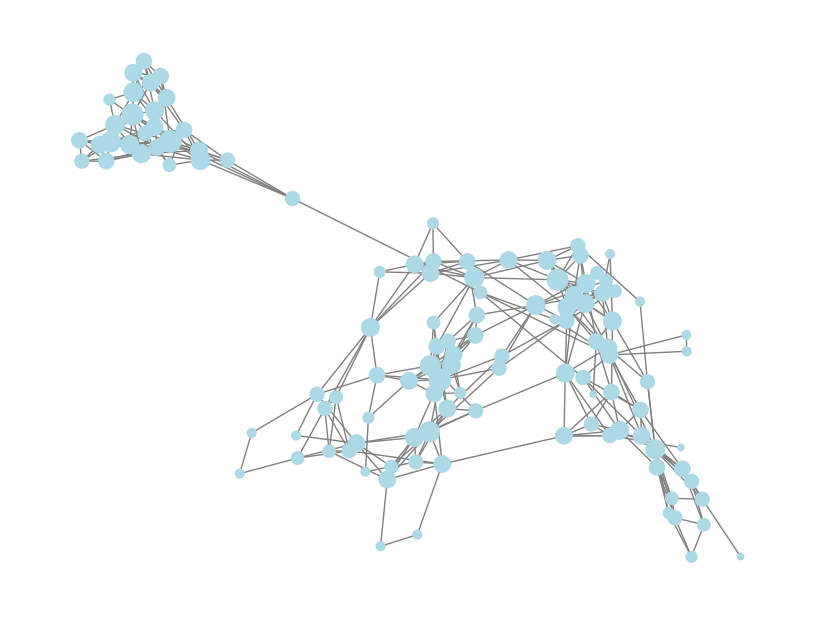

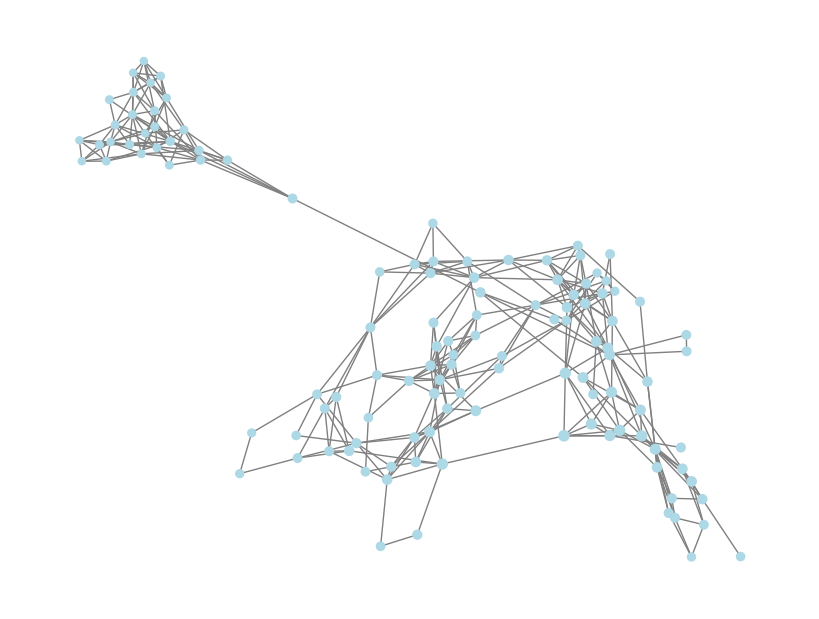

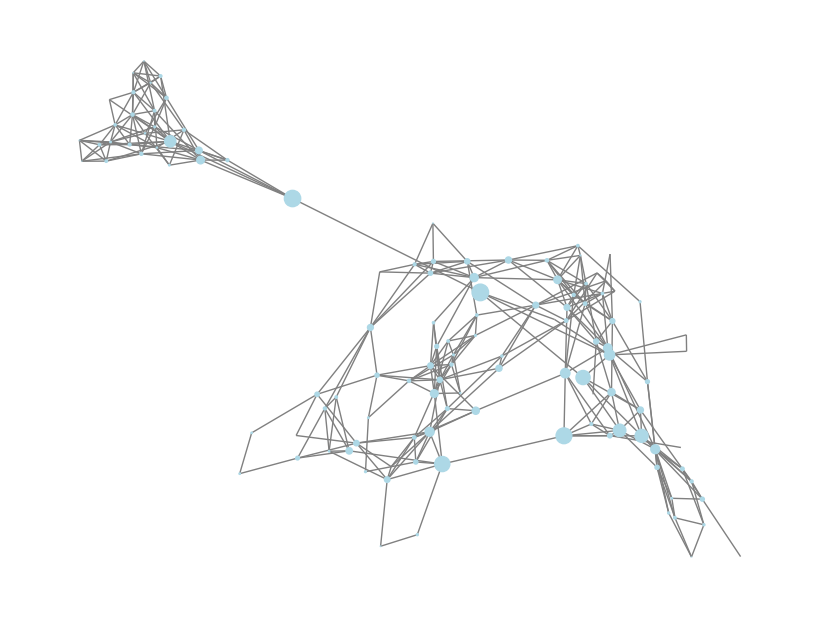

In [64]:
pos = nx.spring_layout(G_highschool)

plt.figure(figsize=(8, 6))
nx.draw(G_highschool, pos,
        nodelist=degrees.keys(), node_size=[v*20 for v in degrees.values()],
        node_color='lightblue', edge_color='gray')
plt.show()


plt.figure(figsize=(8, 6))
nx.draw(G_highschool, pos,
        nodelist=closeness_highschool.keys(), node_size=[v*200 for v in closeness_highschool.values()],
        node_color='lightblue', edge_color='gray')
plt.show()

plt.figure(figsize=(8, 6))
nx.draw(G_highschool, pos,
        nodelist=betweenness_highschool.keys(), node_size=[v*400 for v in betweenness_highschool.values()],
        node_color='lightblue', edge_color='gray')
plt.show()

## Task 2: Random Graph Models

### 2.1 G(n,m) model

Write a `python` function that starts from an empty network and samples m pairs `i` and `j`, and creates edges between those.

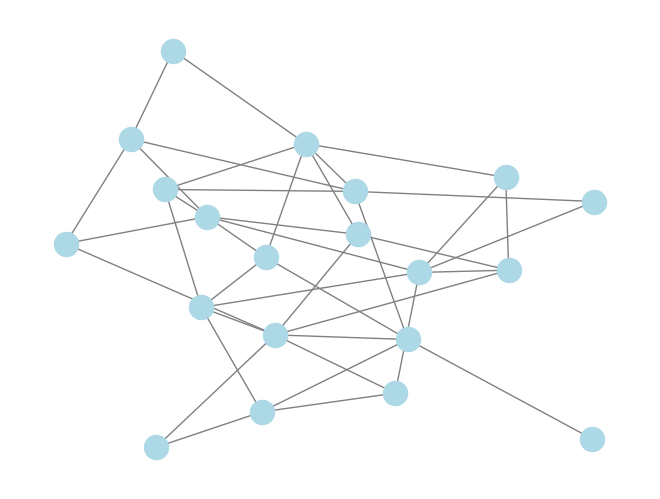

In [22]:
import random
def random_graph_Gnm(n, m):
    """
    Generate a random graph in the G(n, m) model.
    
    Parameters:
        n (int): Number of nodes.
        m (int): Number of edges to add.
    
    Returns:
        G (networkx.Graph): An undirected graph with n nodes and m randomly selected edges.
    """
    # Create an empty graph with n nodes.
    G = nx.empty_graph(n)
    
    # List all possible edges (for an undirected graph).
    possible_edges = [(i, j) for i in range(n) for j in range(i+1, n)]
    
    # Ensure m does not exceed the total possible number of edges.
    if m > len(possible_edges):
        raise ValueError("m is too large. Maximum number of edges is n*(n-1)/2.")
    
    # Randomly select m edges without replacement.
    chosen_edges = random.sample(possible_edges, m)
    
    # Add the selected edges to the graph.
    G.add_edges_from(chosen_edges)
    
    return G

n = 20
m = 40

G_random = random_graph_Gnm(n, m)

# Visualize the resulting graph
pos = nx.spring_layout(G_random)
nx.draw(G_random, pos, node_color='lightblue', edge_color='gray', with_labels=False)


### 2.2 Degree distribution of G(n,m) model

Use your function and the boilerplate code below to create five random networks with $200$ nodes and $300$ links. Visualise the networks, plot their degree distributions and calculate the mean and variance of the distributions.

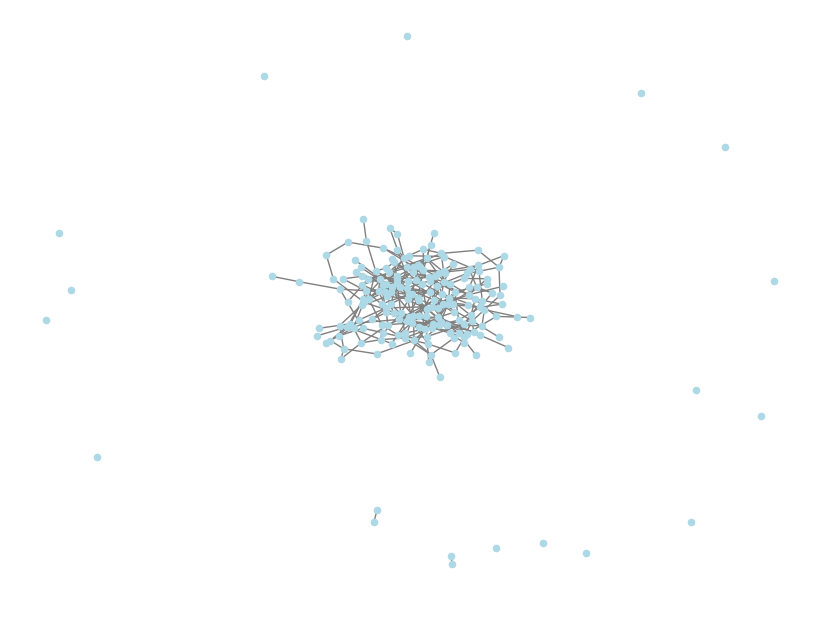

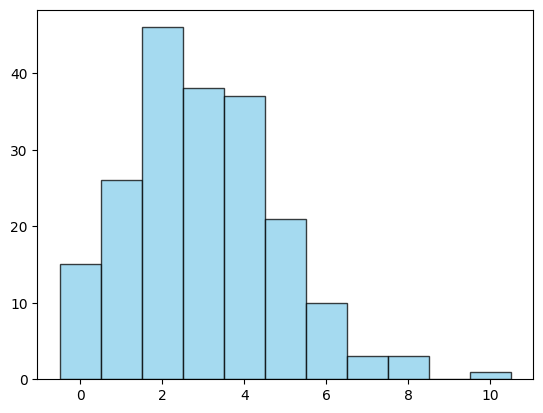

Mean G(n,m) =  3.0
Var G(n,m) =  3.34


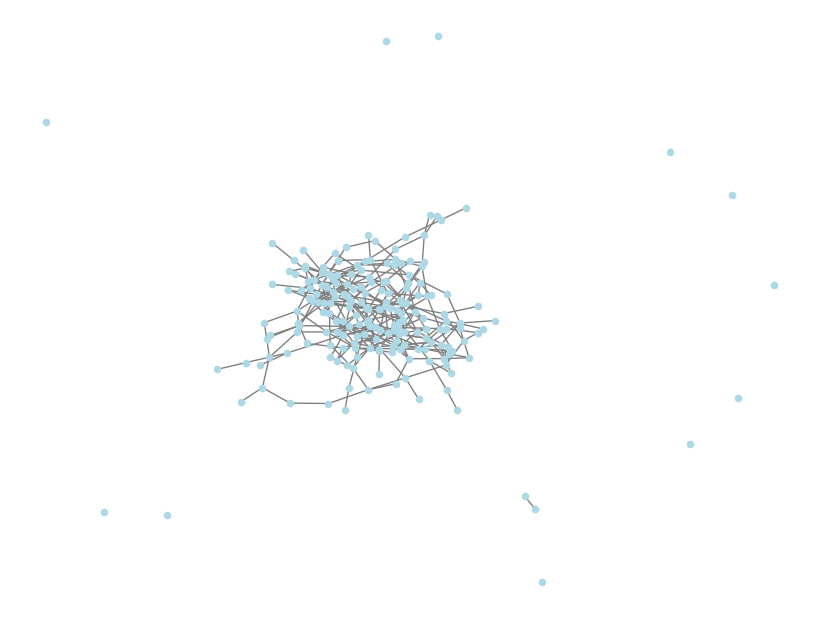

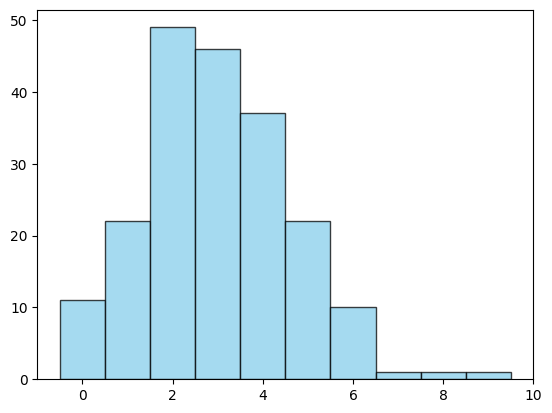

Mean G(n,m) =  3.0
Var G(n,m) =  2.64


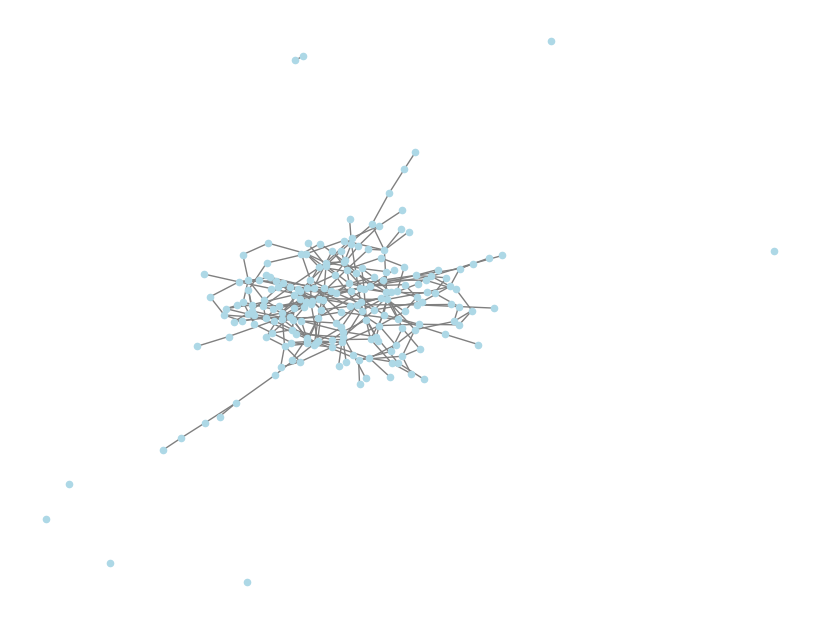

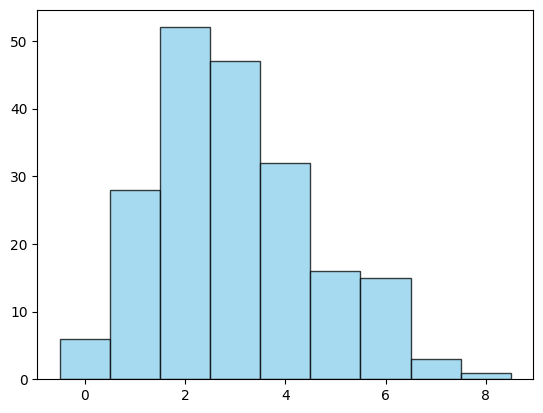

Mean G(n,m) =  3.0
Var G(n,m) =  2.61


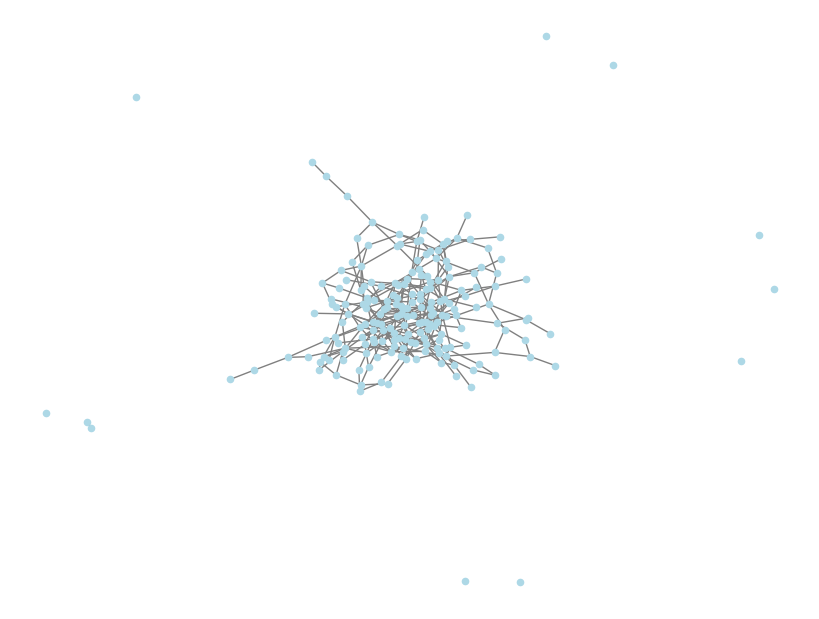

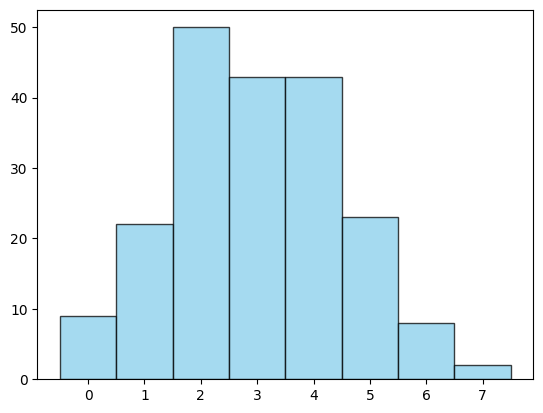

Mean G(n,m) =  3.0
Var G(n,m) =  2.29


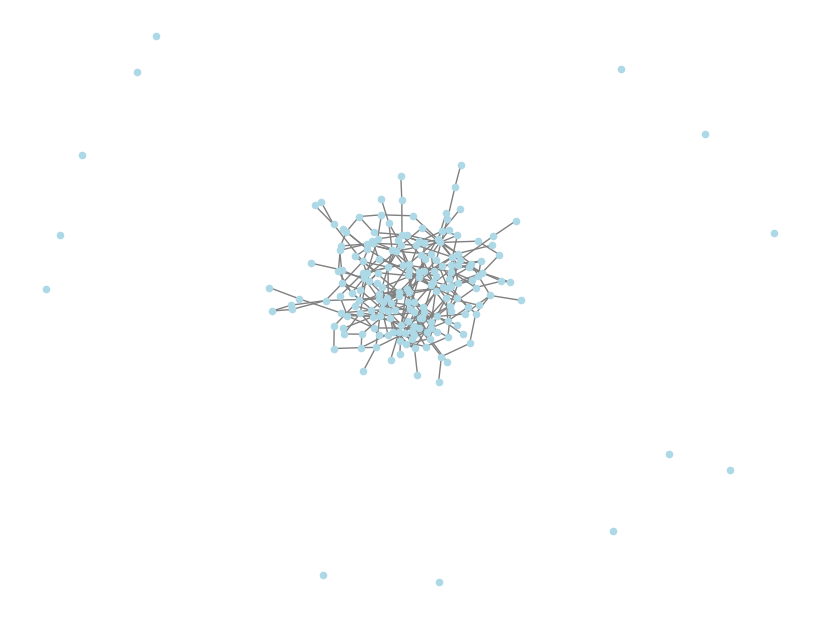

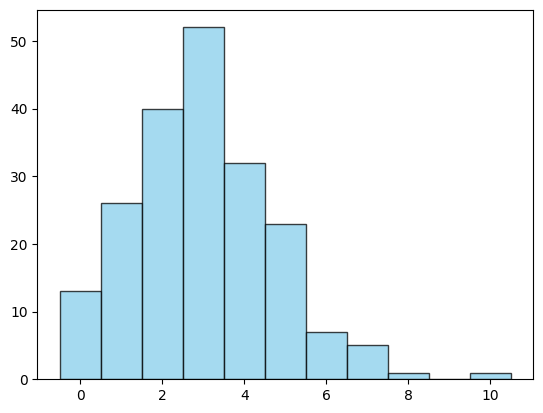

Mean G(n,m) =  3.0
Var G(n,m) =  3.01


In [23]:
#BOILERPLATE_CODE

for i in range(5):
    g = random_graph_Gnm(200, 300)
    plt.figure(figsize=(8, 6))
    nx.draw(g, node_color='lightblue', edge_color='gray', with_labels=False, node_size = 20)
    plt.show()
    degrees = [d for n, d in g.degree()]

    # Determine bin edges for the histogram.
    bins = np.arange(min(degrees), max(degrees) + 2) - 0.5

    plt.clf()
    plt.hist(degrees, bins = bins, color='skyblue', edgecolor='black', alpha=0.75)
    plt.show()
    print("Mean G(n,m) = ", np.mean(degrees))
    print("Var G(n,m) = ", np.var(degrees))

### 2.3 Empirical degree distributions 

Plot the histogram of node degrees for the five empirical networks listed in Task 1 (interpreted as undirected networks). Compare the degree distributions to those of a random graph model with the same number of nodes and links.

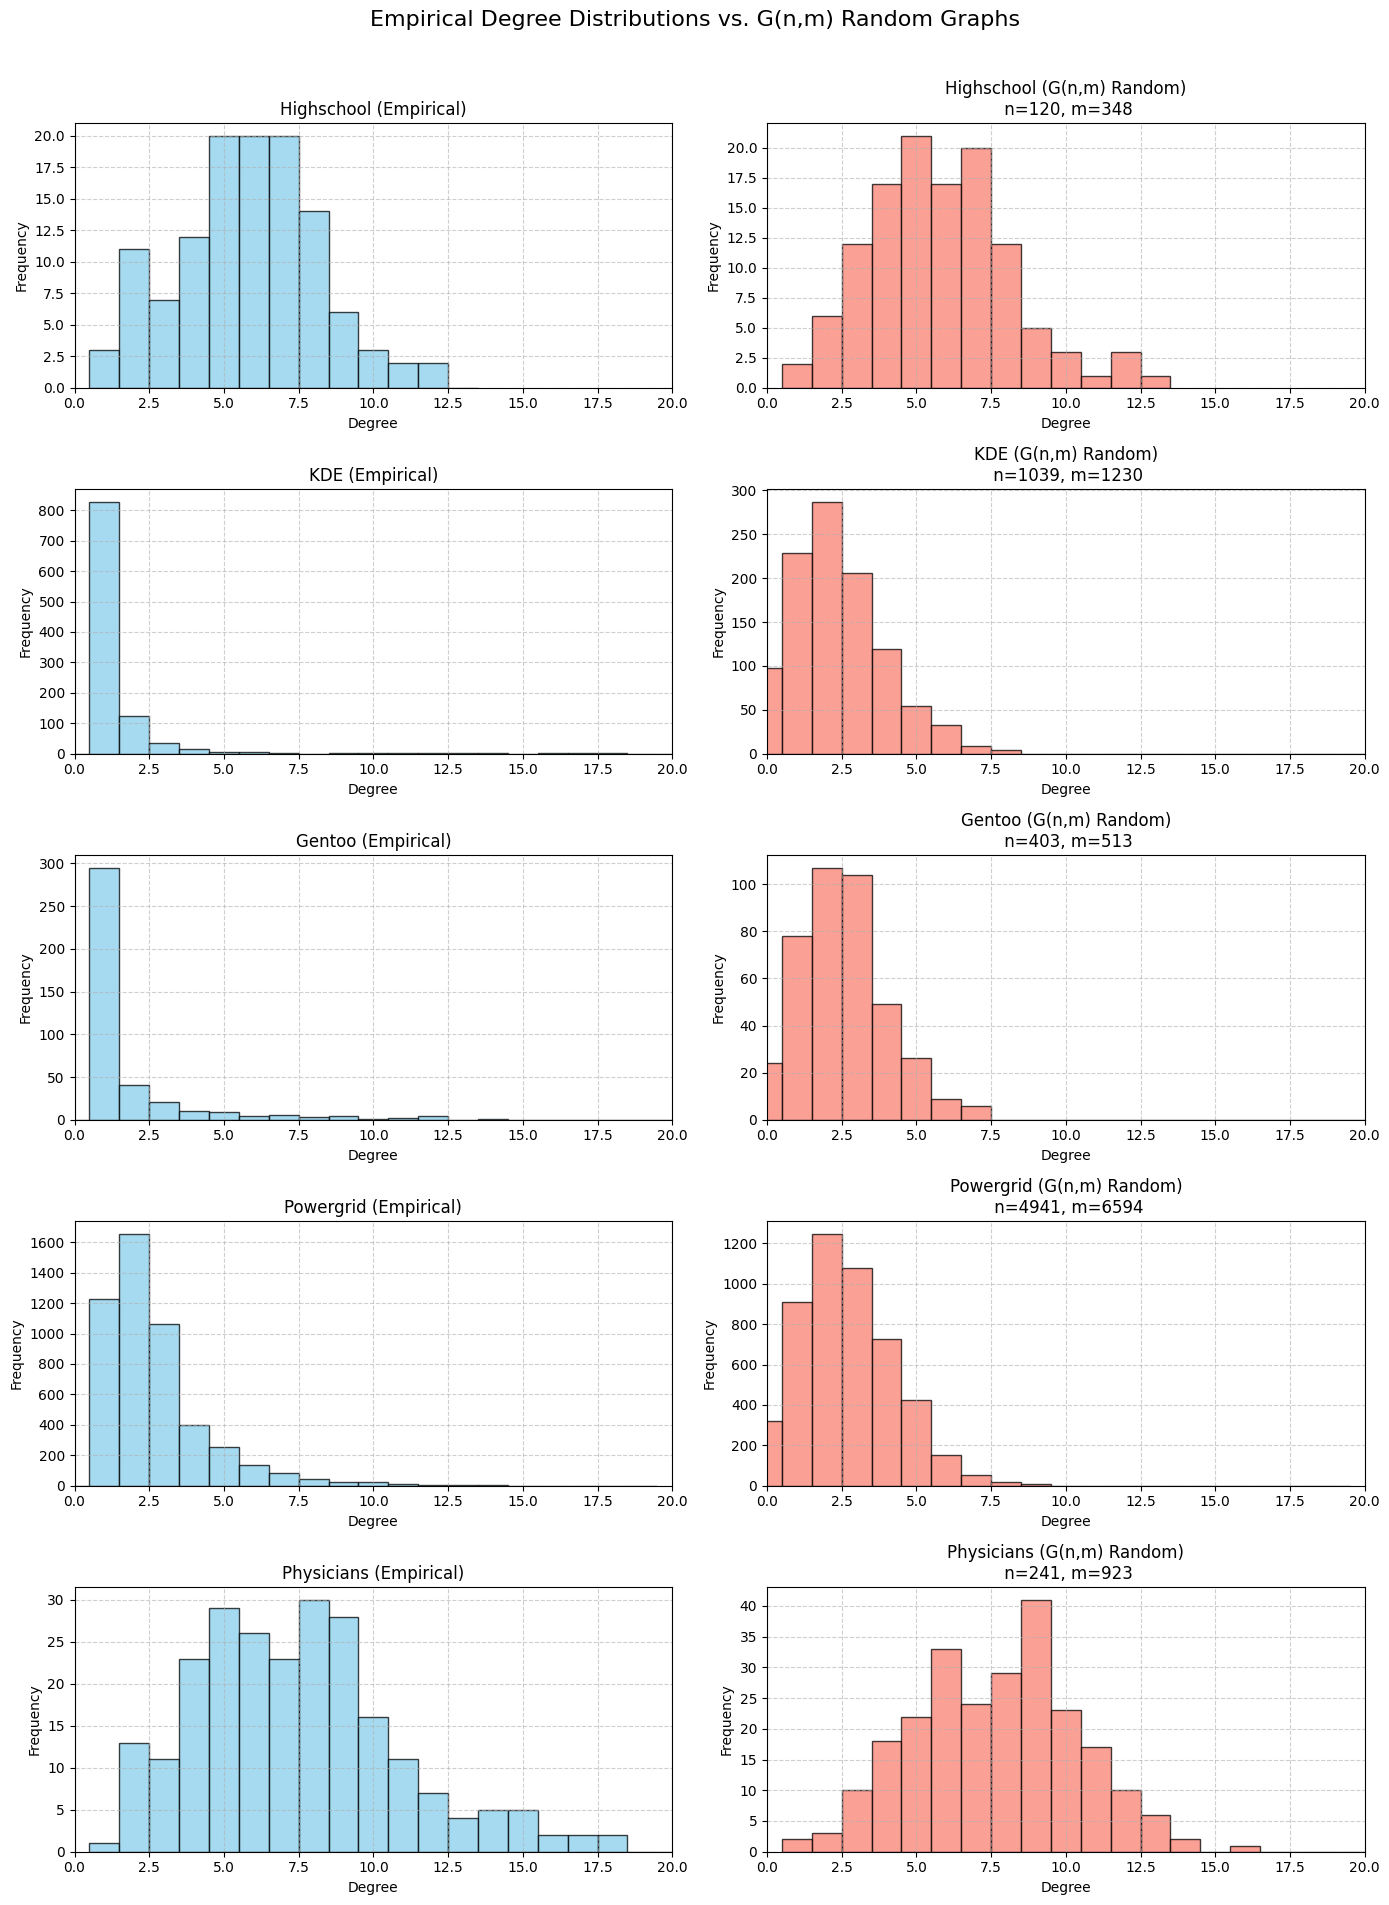

In [70]:
# Empirical networks
networks = {
    "Highschool": nx_from_sqlite('SELECT source, target FROM highschool'),
    "KDE": nx_from_sqlite('SELECT source, target FROM kde'),
    "Gentoo": nx_from_sqlite('SELECT source, target FROM gentoo'),
    "Powergrid": nx_from_sqlite('SELECT source, target FROM powergrid'),
    "Physicians": nx_from_sqlite('SELECT source, target FROM physicians')
}

# Plot empirical degree distributions and random graph comparisons.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
fig.suptitle("Empirical Degree Distributions vs. G(n,m) Random Graphs", fontsize=16)

for idx, (name, G_empirical) in enumerate(networks.items()):
    n_nodes = G_empirical.number_of_nodes()
    m_edges = G_empirical.number_of_edges()
    
    # Get degree distribution for the empirical network.
    empirical_degrees = [d for n, d in G_empirical.degree()]
    
    # Generate a random graph with the same number of nodes and edges.
    G_random = random_graph_Gnm(n_nodes, m_edges)
    random_degrees = [d for n, d in G_random.degree()]
    
    # Define bins for histogram (centering on integer degree values)
    min_deg = min(min(empirical_degrees), min(random_degrees))
    max_deg = max(max(empirical_degrees), max(random_degrees))
    bins = np.arange(min_deg, max_deg + 2) - 0.5

    # Plot the empirical degree histogram.
    ax_emp = axes[idx, 0]
    ax_emp.hist(empirical_degrees, bins=bins, color='skyblue', edgecolor='black', alpha=0.75)
    ax_emp.set_xlim(0,20)
    ax_emp.set_title(f"{name} (Empirical)")
    ax_emp.set_xlabel("Degree")
    ax_emp.set_ylabel("Frequency")
    ax_emp.grid(True, linestyle='--', alpha=0.6)
    
    # Plot the random graph degree histogram.
    ax_rand = axes[idx, 1]
    ax_rand.hist(random_degrees, bins=bins, color='salmon', edgecolor='black', alpha=0.75)
    ax_rand.set_xlim(0,20)
    ax_rand.set_title(f"{name} (G(n,m) Random)\n n={n_nodes}, m={m_edges}")
    ax_rand.set_xlabel("Degree")
    ax_rand.set_ylabel("Frequency")
    ax_rand.grid(True, linestyle='--', alpha=0.6)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## Task 3: Triadic closure in social networks

### 3.1 Calculating the clustering coefficient

Implement `python` functions that calculate the local and global clustering coefficient in an (undirected) network. Test your method on the small toy example from lecture L03, slide "Global clustering coefficient".

In [71]:
def local_clustering_coefficient(G, node):

    neighbors = list(G.neighbors(node))
    d = len(neighbors)
    if d < 2:
        return 0.0 
    
    # Count the number of edges between the neighbors.
    links = 0
    for i in range(d):
        for j in range(i+1, d):
            if G.has_edge(neighbors[i], neighbors[j]):
                links += 1
                
    return (2 * links) / (d * (d - 1))


def global_clustering_coefficient(G):

    coeffs = [local_clustering_coefficient(G, node) for node in G.nodes()]
    return np.mean(coeffs)

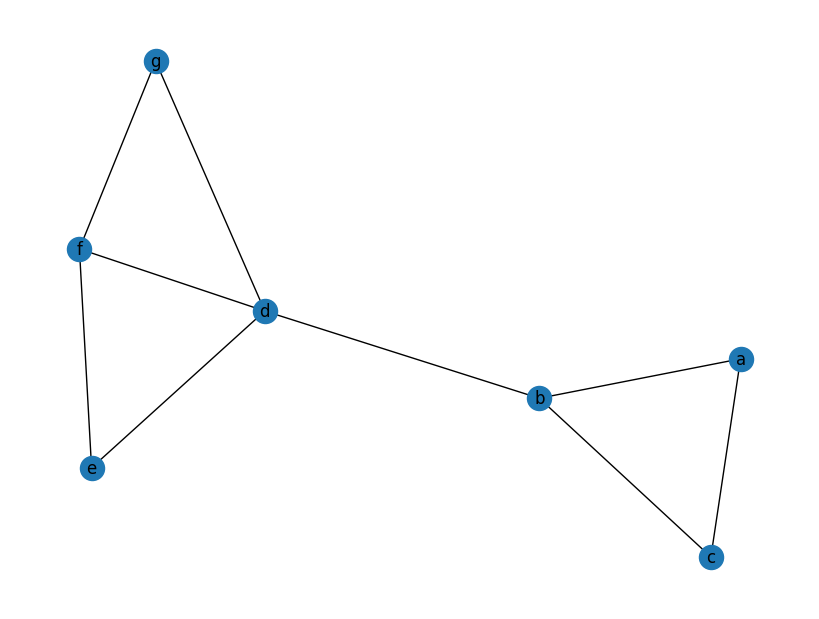

Local clustering coefficient of node 'b': 0.3333333333333333
Local clustering coefficient of node 'd': 0.3333333333333333
Global clustering coefficient: 0.761904761904762


In [72]:
G_toy = nx.Graph()

G_toy.add_edges_from([("a", "c"), 
                      ("a", "b"), 
                      ("b", "c"), 
                      ("b", "d"),
                      ("d", "e"),
                      ("d", "f"),
                      ("d", "g"),
                      ("e", "f"),
                      ("f", "g")])
plt.figure(figsize=(8, 6))
nx.draw(G_toy, with_labels=True)
plt.show()

print("Local clustering coefficient of node 'b':", local_clustering_coefficient(G_toy, 'b'))
print("Local clustering coefficient of node 'd':", local_clustering_coefficient(G_toy, 'd'))
print("Global clustering coefficient:", global_clustering_coefficient(G_toy))

### 3.2 Empirical vs. random clustering coefficient

Use your function to calculate the global clustering coefficient of the `highschool` data and compare it to the global clustering coefficient in random networks with the same number of nodes and links. Would you say that the level of triadic closure in this social network is significantly higher than what we would expect at random?

Global clustering coefficient for highschool network: 0.4468


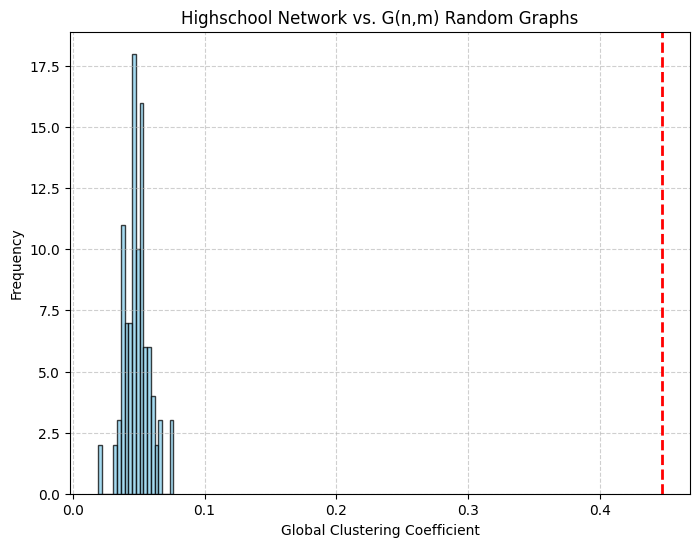

In [73]:
global_cc_highschool = global_clustering_coefficient(G_highschool)
print("Global clustering coefficient for highschool network: {:.4f}".format(global_cc_highschool))

n_nodes = G_highschool.number_of_nodes()
m_edges = G_highschool.number_of_edges()

# To check whether the gcc of the highschool is different from the random graph, we generate 100 graphs
n_graphs = 100
random_ccs = []

for _ in range(n_graphs):
    G_random = random_graph_Gnm(n_nodes, m_edges)
    random_ccs.append(global_clustering_coefficient(G_random))

# As a histogram
plt.figure(figsize=(8, 6))
plt.hist(random_ccs, bins=20, color='skyblue', edgecolor='black', alpha=0.75)
plt.axvline(global_cc_highschool, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Global Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Highschool Network vs. G(n,m) Random Graphs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

